## Udacity A/B Testing—Final Course Project

1. [Context](#section1)<br/>
2. [Project Challenge](#section2)<br/>
    2.1 [Status quo](#section2_1)<br/>
    2.2 [Treatment](#section2_2)<br/>
    2.3 [Reasoning](#section2_3)<br/>
3. [Experiment Setup](#section3)<br/>
    3.1 [Unit of diversion](#section3_1)<br/>
    3.2 [Initial hypotheses](#section3_2)<br/>
    3.3 [Metric choice and practical relevance](#section3_3)<br/>
    3.4 [Hypotheses revisited](#section3_4)<br/>
    3.5 [Measuring variability in metrics](#section3_5)<br/>
    3.6 [Setting alpha and beta](#section3_6)<br/>
    3.7 [Determining experiment sample size](#section3_7)<br/>
    3.8 [Experiment exposure and duration](#section3_8)<br/>
    3.9 [Accounting for multiple hypotheses](#section3_9)<br/>
4. [Data Analysis](#section4)<br/>
    4.1 [Loading experiment data](#section4_1)<br/>
    4.2 [Sanity check](#section4_2)<br/>
    4.3 [Test analysis](#section4_3)<br/>
5. [Interpretation of Results and Recommendations](#section5)<br/>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np 
import pandas as pd
from scipy import stats 
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import binom_test

/kaggle/input/Final Project Results - Experiment.csv
/kaggle/input/Final Project Results - Control.csv


### 1. Context
<a id='section1'></a>

In collaboration with Google, Udacity provides an [introductory course to A/B testing](https://www.udacity.com/course/ab-testing--ud257). The course covers the design and analysis of A/B tests using a frequentist approach. This notebook provides a walkthrough of the course's final project.

### 2. Project Challenge (provided by Udacity)
<a id='section2'></a>

Udacity's mission is to power careers through tech education. Working towards this mission, the company aims to provide a stimulating learning experience that is tailored to the individual learner and supported by experienced coaches. To improve its services, Udacity tinkered with changing the user flow on its website and set up an A/B test titled "Free Trial Screener" to test its idea.

<a id='section2_1'></a>
#### 2.1 Status quo

* At the time of the experiment, Udacity courses have two options on the course overview page: "start free trial", and "access course materials".

* If students click "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first. 

* If students click "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.


<a id="section2_2"></a>
#### 2.2 Treatment

* In the experiment, Udacity tests a change where if students click "start free trial", they are asked how much time they have available to devote to the course. 

* If students indicate 5 or more hours per week, they are taken through the checkout process as usual. 

* If they indicate fewer than 5 hours per week, a message appears indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, students have the option to continue enrolling in the free trial, or access the course materials for free instead. [This screenshot](https://drive.google.com/file/d/0ByAfiG8HpNUMakVrS0s4cGN2TjQ/view) shows what the experiment looks like.

<a id="section2_3"></a>
#### 2.3 Reasoning

* The hypothesis is that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course.

* If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

### 3. Experiment Setup
<a id="section3"></a>

<a id="section3_1"></a>
#### 3.1 Unit of diversion (provided by Udacity)

The unit of diversion is a <i>cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward</i>. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

<a id="section3_2"></a>
#### 3.2 Initial hypotheses

Given the challenge outlined above, we can define null and alternative hypotheses for our experiment. These hypotheses will be revisited and further specified in 3.4.

* $ H_{0}$: The treatment has no effect on the share of people who enroll in the free trial
* $ H_{1}$: The treatment reduces the share of people who enroll in the free trial


* $ H_{0}$: The treatment has no effect on the share of people who leave the free trial
* $ H_{1}$: The treatment improves the overall student experience thereby reducing the share of people who leave the free trial


* $ H_{0}$: The treatment has no effect on the number of people who continue past the free trial
* $ H_{1}$: The treatment affects the number of people who continue past the free trial

<a id="section3_3"></a>
#### 3.3 Metric choice and practical relevance

To test these hypotheses, we need to define appropriate evaluation metrics. Evaluation metrics should be sensitive enough that they pick up the changes we care about. At the same time, they should be robust against the changes we do not care about.

Further, it is suggested to define a set of invariant metrics/control variables. Later on, these can help to "sanity check" the results and experiment setup. Invariant metrics are metrics that we expect not to change between test and control group. 

Thereby, we care not only about statistical significance but also about whether changes in metrics are practially relevant (dmin) as treatments might be not worth the resources to implement (despite being statistically significant).

For the project, Udacity provides a pool of seven metrics to choose from. Additionally, the practical relevance level of each metric is given. To actually derive metrics (or in this case: to choose), I find it helpful to first visualize the experiment. A visualization with the provided metric options is shown below:

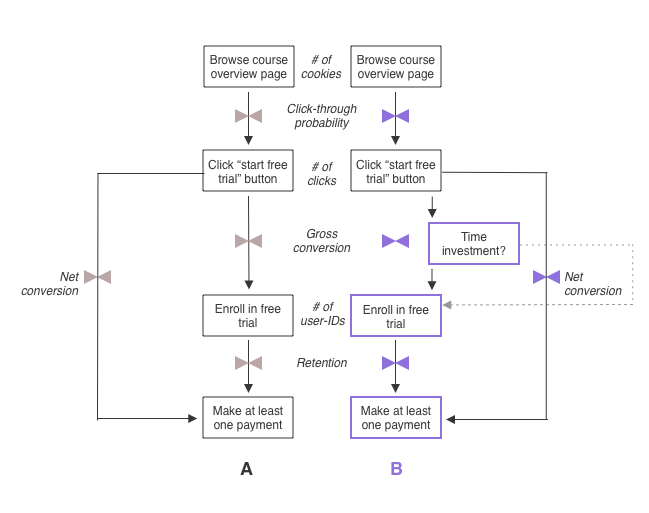

&nbsp;

##### 3.3.1 Invariant Metrics

The metrics we don't expect to change between treatment and control group are the ones on top as they are independent from the treatment. Although it might be sufficient to only use the click-through-probability as an invariant metric (since it is defined by the other two), it is beneficial to track the other two as well to check back on them in case the click-through-probabilities vary unexpectedly.


| <p align="left">Metric</p>                    | <p align="left">Formula</p>                                                             | <p align="left">dmin</p> |
| ------------------------- | ---------------------------------------------------------------------- | --------------------------------------- |
| <p align="left">Number of cookies</p>        | <p align="left">$ \text{C = } \text{# of unique daily cookies to view course overview page}$</p>          | <p align="left">3000</p>                                |
| <p align="left">Number of clicks</p>       | <p align="left">$ \text{CL = } \text{# of unique daily cookies to click "start free trial" button}$</p>   | <p align="left">240</p>                                  |
| <p align="left">Click-through-probability</p> | <p align="left">$ \text{CTP = } \frac{CL}{C}$</p>                                                            | <p align="left">0.01</p>                                 |



&nbsp;


##### 3.3.2 Evaluation Metrics

In contrast to the invariant metrics, we expect the following metrics to be affected by the treatment and vary between control and treatment group.

* Gross conversion: we expect gross conversion in the treatment group to be lower than gross conversion in the control group as, through the treatment, we are trying to divert users that don't seem to be a good fit for the paid option (likely to churn due to limited time resources --> time commitment of less than 5 hours/week) to the freely accessible course materials.

* Retention: at the same time, we expect the retention rate to increase as the treatment should have filtered out users who are likely to churn.

* Net conversion: this metric is a product of the two former. From a business perspective, we hope to see an increase but it could vary in each direction or stay constant depending on gross conversion and retention effects.

Lastly, we would also expect the number of user-ids (i.e. the number of users who enroll in the free trial; dmin=-50) to decrease. However, the metric is not normalized and would not provide any information we are not already capturing with gross conversion (as the number of clicks will be controlled for). Thus, we will not use it as an evaluation metric.

Additional thoughts:
This being said, it would have been also interesting to track whether the treatment increases the total number of people who opt for the freely available course materials as users in this group potentially want to upgrade later on. Based on the reasoning of this experiment, we would expect the total number of people who opt for the freely available materials to increase since we expect that the treatment reduces direct churn from people who are frustrated with the free trial (users who drop out of the free trial are less likely to access the free materials afterwards). However, given the provided data this is not possible. In case such an effect would indeed exist and materialize within the duration of the experiment, impact gross conversion rates would be positively impacted (assuming conversion rates from users who first learn with the freely accessible materials and then upgrade do not decline).



 
| <p align="left">Metric</p>                   | <p align="left">Formula</p>                                                               | <p align="left">dmin</p> |
| ------------------------- | ---------------------------------------------------------------------- | --------------------------------------- |
| <p align="left">Gross Conversion</p>        | <p align="left">$ \text{CG = } \frac{\text{# of user-ids that enrolled}}{CL}$</p>      | <p align="left">-0.01</p>                                    |
| <p align="left">Retention</p>         | <p align="left">$ \text{R = } \frac{\text{# of user-ids that paid}}{\text{# of user-ids that enrolled}}$</p>  | <p align="left">0.01</p>                                   |
| <p align="left">Net Conversion</p> | <p align="left">$ \text{CN = } \frac{\text{# of user-ids that paid}}{CL}$</p>                                                         | <p align="left">0.0075</p>                                    |

&nbsp;

<a id="section3_4"></a>
#### 3.4 Hypotheses revisited

Given the available and selected metrics, we can now specify our hypotheses. While it could be argued that in some cases a one-sided test is appropriate, we are thereby sticking with a more conservative two-sided test.


* $ H_{0}: CG_{treatment} = CG_{control} $
* $ H_{1}: CG_{treatment} \neq CG_{control} $


* $ H_{0}: R_{treatment} = R_{control} $
* $ H_{1}: R_{treatment} \neq R_{control} $


* $ H_{0}: CN_{treatment} = CN_{control} $
* $ H_{1}: CN_{treatment} \neq CN_{control} $


Note: later on, we will drop the second hypothesis as it would demand a sample size that requires the the test to run unreasonably long (see 3.8).

<a id="section3_5"></a>
#### 3.5 Measuring variability in metrics

##### 3.5.1 Collecting baseline data (provided by Udacity)


| <p align="left">Metric</p>                   | <p align="left">Estimator</p> |
| ------------------------- | ---------------------------------------------------------------------- |
| <p align="left">Number of cookies</p>           | <p align="left">40000</p>      |
| <p align="left">Number of clicks</p>            | <p align="left">3200</p>       |
| <p align="left">Number of user-ids</p>          | <p align="left">660</p>        |
| <p align="left">CTP</p>                         | <p align="left">0.08</p>       |
| <p align="left">Gross conversion</p>            | <p align="left">0.20625</p>    |
| <p align="left">Retention</p>                   | <p align="left">0.53</p>       |
| <p align="left">Net conversion</p>              | <p align="left">0.1093125</p>  |



In [2]:
#Storing baseline data
d = {"Metric Name": ["Cookies", "Clicks", "User-ids", "Click-through-probability", "Gross conversion", "Retention", "Net conversion"], 
     "Estimator": [40000, 3200, 660, 0.08, 0.20625, 0.53, 0.109313],
     "dmin": [3000, 240, -50, 0.01, -0.01, 0.01, 0.0075]}
md = pd.DataFrame(data=d, index=["C", "CL", "ID", "CTP", "CG", "R", "CN"])
md

,Metric Name,Estimator,dmin
C,Cookies,40000.000000,3000.0000
CL,Clicks,3200.000000,240.0000
ID,User-ids,660.000000,-50.0000
CTP,Click-through-probability,0.080000,0.0100
CG,Gross conversion,0.206250,-0.0100
R,Retention,0.530000,0.0100
CN,Net conversion,0.109313,0.0075


##### 3.5.2 Calculating standard errors

Next, we need to calculate the standard deviation of the sampling distribution of the sample mean (standard error, in short) for each of the evaluation metrics. To be more precise, in this case we calculate the estimated standard errors of the sample proportions as our evaluation metrics are probabilities. The standard error is an estimate of how far the sample proportion is likely to be from the population proportion.

###### 3.5.2.1 Scaling

Since the sample size given by Udacity is n = 5000 cookies, we first need to scale the collected count data, i.e. the number of cookies, the number of clicks and the number of user-ids.

In [3]:
#create new column to store scaled estimators
md.insert (2, "Scaled_Est", np.nan)

#scale count estimates
scaling_factor = 5000/md.loc["C"]["Estimator"]

for i in ["C", "CL", "ID"]:
    md.at[i, "Scaled_Est"] = md.loc[i]["Estimator"] * scaling_factor
md

,Metric Name,Estimator,Scaled_Est,dmin
C,Cookies,40000.000000,5000.0,3000.0000
CL,Clicks,3200.000000,400.0,240.0000
ID,User-ids,660.000000,82.5,-50.0000
CTP,Click-through-probability,0.080000,NaN,0.0100
CG,Gross conversion,0.206250,NaN,-0.0100
R,Retention,0.530000,NaN,0.0100
CN,Net conversion,0.109313,NaN,0.0075


###### 3.5.2.2 Assumptions

Since the unit of diversion is the same as the unit of analysis (denominator of the metric formula) for each evaluation metric (cookie in the case of Gross Conversion and Net Conversion and user-id in the case of Retention) and we can make assumptions about the distributions of the metrics (binominal), we can calculate the standard errors analytically (instead of empirically).

Further, as n is relatively large in each case, we can assume that the sampling distribution of a sample proportion approaches a normal distribution (due to the Central Limit Theorem). We can also use a rule such as the [3-standard-deviation rule](https://en.wikipedia.org/wiki/Binomial_distribution) to check if n is large enough:

In [4]:
def checkN (n, p, metric):
    '''Given sample size n and probability p, return whether n is large enough to pass the 3-standard deviation rule,
    i.e. whether we can assume that the distribution can be approximated by the normal distribution'''
    if n > 9*((1-p)/p) and n > 9*(p/(1-p)):
        result = print(metric,":  n =", n, "is large enough to assume normal distribution approximation")
    else:
        result = print(metric,":  n =", n, "is not large enough to assume normal distribution approximation")
    return result

#check whether n is large enough to assume normal distribution approximation
for i,j in zip(["CL", "ID", "CL"],["CG", "R", "CN"]):
    checkN (md.at[i, "Scaled_Est"], md.at[j,"Estimator"], md.at[j,"Metric Name"])

Gross conversion :  n = 400.0 is large enough to assume normal distribution approximation
Retention :  n = 82.5 is large enough to assume normal distribution approximation
Net conversion :  n = 400.0 is large enough to assume normal distribution approximation


###### 3.5.2.3 Computing standard errors

Given above assumptions we can approximate the standard error through:

$ SE = \sqrt{\frac{\hat{p}*(1-\hat{p})}{n}}$

with $ \sqrt{\hat{p}*(1-\hat{p})}$ estimating the population standard deviation.



In [5]:
#create new column to store standard errors
md["SE"] = np.nan

#formula to calculate standard deviation
def standardError (n, p):
    '''Return the standard deviation for a given probability p and sample size n'''
    return (p*(1-p)/n)**0.5

#calculating standard errors for evaluation metrics and store them in md
for i in ["CG", "CN"]:
    md.at[i, "SE"] = standardError(md.loc["CL"]["Scaled_Est"], md.loc[i]["Estimator"]) 
    
md.at["R", "SE"] = standardError(md.loc["ID"]["Scaled_Est"], md.loc["R"]["Estimator"])
md


,Metric Name,Estimator,Scaled_Est,dmin,SE
C,Cookies,40000.000000,5000.0,3000.0000,NaN
CL,Clicks,3200.000000,400.0,240.0000,NaN
ID,User-ids,660.000000,82.5,-50.0000,NaN
CTP,Click-through-probability,0.080000,NaN,0.0100,NaN
CG,Gross conversion,0.206250,NaN,-0.0100,0.020231
R,Retention,0.530000,NaN,0.0100,0.054949
CN,Net conversion,0.109313,NaN,0.0075,0.015602


#### 3.6 Setting alpha and beta
<a id="section3_6"></a>

We set the alpha level to 0.05 and the statistical power to 0.80 (by setting beta to 0.20).

In [6]:
#storing alpha and beta in a dictionary
error_prob = {"alpha": 0.05, "beta": 0.20}
error_prob

{'alpha': 0.05, 'beta': 0.2}

#### 3.7 Determining experiment sample size
<a id="section3_7"></a>

Approach A:

If we assume that the standard deviations of the population proportion and the sample proportion are equal and that also the sample sizes of treatment and control group are the same, then the required experiment sample size per group can be determined through (as outlined [here](http://vanbelle.org/chapters%5Cwebchapter2.pdf)):

$ n = 2(z_{1-\alpha/2}+z_{1-\beta})^2*\frac{\sigma^2}{dmin^2} $

with $ \sigma = SE * \sqrt{n} = \sqrt{\hat{p}*(1-\hat{p})}$    ,whereby here n is the sample size we used to calculate SE earlier.

&nbsp;

Approach B:

If we do not assume common standard deviations then a more precise way to determine the required sample size would be (as outlined [here](http://vanbelle.org/chapters%5Cwebchapter2.pdf)):


$ n = \frac{(z_{1-\alpha/2}*\sqrt{2*\hat{p}*(1-\hat{p})}+z_{1-\beta}*\sqrt{\hat{p}*(1-\hat{p})+(\hat{p}+dmin)*(1-(\hat{p}+dmin))})^2}{dmin^2}$

This is also the approach used by many online sample size calculators such as the one by [Evan Miller ](https://www.evanmiller.org/ab-testing/sample-size.html) and we will apply it in the following. 

&nbsp;

Further considerations

When we calculate the experiment sample size we have to keep in mind that n gives us the sample size per group. For a classical A/B test, there are two groups. Further, we want to calculate the experiment sample size in terms of cookies that visit the page. Thus, we also need to account for the circumstance that our evaluation metrics' units of analysis are clicks and user-ids, respectively.

The total experiment sample size per evaluation metric is hence given by:

$ n_{c} = \frac{n}{CTP}*2 $


and

$ n_{c} = \frac{\frac{n}{CTP}}{CG}*2 $


In [7]:
#create new column n_c to store sample sizes
md["n_C"] = np.nan

#define function for approach B
def get_sampleSize (alpha, beta, p, dmin):
    '''Return sample size given alpha, beta, p and dmin'''
    return (pow((stats.norm.ppf(1-alpha/2)*(2*p*(1-p))**0.5+stats.norm.ppf(1-beta)*(p*(1-p)+(p+dmin)*(1-(p+dmin)))**0.5),2))/(pow(dmin,2))

#calculate sample sizes for evaluation metrics with defined adjustments and store results in md
for i in ["CG", "CN"]:
    md.at[i, "n_C"] = round((get_sampleSize(error_prob["alpha"], error_prob["beta"], md.loc[i]["Estimator"], md.loc[i]["dmin"])/md.loc["CTP"]["Estimator"])*2)

md.at["R", "n_C"] = round(((get_sampleSize(error_prob["alpha"], error_prob["beta"], md.loc["R"]["Estimator"], md.loc["R"]["dmin"])/md.loc["CTP"]["Estimator"])/md.loc["CG"]["Estimator"])*2)
md


,Metric Name,Estimator,Scaled_Est,dmin,SE,n_C
C,Cookies,40000.000000,5000.0,3000.0000,NaN,NaN
CL,Clicks,3200.000000,400.0,240.0000,NaN,NaN
ID,User-ids,660.000000,82.5,-50.0000,NaN,NaN
CTP,Click-through-probability,0.080000,NaN,0.0100,NaN,NaN
CG,Gross conversion,0.206250,NaN,-0.0100,0.020231,638940.0
R,Retention,0.530000,NaN,0.0100,0.054949,4737771.0
CN,Net conversion,0.109313,NaN,0.0075,0.015602,685336.0


Given our calculations, we would need around 638,940 pageviews (cookies) to test the first hypothesis (given our assumptions on alpha, beta, baseline conversions and dmin). To additionally test the third hypothesis, we would need a total of 685,336 pageviews. And, in case we would like to also test the second hypothesis, we would need a total of around 4,737,771 pageviews.

#### 3.8 Experiment exposure and duration
<a id="section3_8"></a>

Now, for each case, we can calculate how many days we would approximately need to run the experiment in order to reach n_C. According to the challenge description, we are thereby assuming that there are no other experiments we want to run simultaneously. So, theoretically, we could divert 100% of the traffic to our experiment (i.e. about 50% of all visitors would then be in the treatment condition). Given our estimation that there are about 40,000 unique pageviews per day, this would result in:

In [8]:
#traffic diverted to experiment [0:1]
traffic_diverted = 1

#Days it would take to run experiment for each case
for i, j in zip(["CG", "CN", "R"],["CG", "CG+CN", "CG+CN+R"]):
   print("Days required for",j,":", round(md.loc[i]["n_C"]/(md.loc["C"]["Estimator"]*traffic_diverted),2))


Days required for CG : 15.97
Days required for CG+CN : 17.13
Days required for CG+CN+R : 118.44


We see that we would need to run the experiment for about 119 days in order to test all three hypotheses (and this does not even take into account the 14 additional days (free trial period) we have to wait until we can evaluate the experiment). Such a duration (esp. with 100% traffic diverted to it) appears to be very risky. First, we cannot perfom any other experiment during this period (opportunity costs). Secondly, if the treatment harms the user experience (frustrated students, inefficient coaching resources) and decreases conversion rates, we won't notice it (or cannot really say so) for more than four months (business risk). <i>Consequently, it seems more reasonable to only test the first and third hypothesis and to discard retention as an evaluation metric.</i> Especially since net conversion is a product of rentention and gross conversion, so that we might be able to draw inferences about the retention rate from the two remaining evaluation metrics.

So, how much traffic should we divert to the experiment? Given the considerations above, we want the experiment to run relatively fast and for not more than a few weeks. Also, as the nature of the experiment itself does not seem to be very risky (e.g. the treatment doesn't involve a feature that is critical with regards to potential media coverage), we can be confident in diverting a high percentage of traffic to the experiment. Still, since there is always the potential that something goes wrong during implemention, we may not want to divert all of our traffic to it. Hence, 80% (22 days) would seem to be quite reasonable. <i>However, when we look at the data provided by Udacity (see 4.1) we see that it takes 37 days to collect 690,203 pageviews, meaning that they most likely diverted somewhere between 45% and 50% of their traffic to the experiment</i>


In [9]:
#traffic diverted to experiment
traffic_diverted = 0.47

#Days it would take to run experiment if we use net conversion and gross coversion as evaluation metrics
print("Experiment duration in days, CN+CG: ",round(md.loc["CN"]["n_C"]/(md.loc["C"]["Estimator"]*traffic_diverted),2))

Experiment duration in days, CN+CG:  36.45


#### 3.9 Accounting for multiple hypotheses?
<a id="section3_9"></a>

As we now have more than one hypothesis, the chance to get false positives increases. However, our metrics are not fully independent which is why the true probability for false positives will still be lower than 9.75% (that's the case for independent metrics). We could then use family-wise error rate such as Bonferroni or false discovery rate methods to account for the multiple hypotheses problem. However, they have flaws as well (e.g. we could easily end up with more false negatives; see [here](https://multithreaded.stitchfix.com/blog/2015/10/15/multiple-hypothesis-testing/) and [here](https://www.statisticshowto.datasciencecentral.com/multiple-testing-problem/)). Hence, given that the chance to get more false positives is only slightly increased in this case, we won't control for multiple hypothese here.

### 4. Data Analysis
<a id="section4"></a>

<a id="section4_1"></a>
#### 4.1 Loading experiment data

In [10]:
#loading experiment data into new dataframes
control = pd.read_csv("../input/Final Project Results - Control.csv") 
experiment = pd.read_csv("../input/Final Project Results - Experiment.csv")

#check if loaded correctly
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [11]:
#check if loaded correctly
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


In [12]:
#check number of entries
control.count()

Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64

In [13]:
#check number of entries
experiment.count()

Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64

In [14]:
#check sample size and store it as sample_size
sample_size_control = control["Pageviews"].sum()
sample_size_experiment = experiment["Pageviews"].sum()
sample_size = sample_size_control+sample_size_experiment
sample_size

690203

#### 4.2 Sanity check
<a id="section4_2"></a>

To ensure that the experiment has been run properly, we first conduct a sanity check using the three invariant metrics outlined above (3.3.1). We have two counts (number of cookies, number of clicks) and one probability. As stated earlier, we would expect that these metrics do not differ significantly between control and treatment group. Otherwise, this would imply that someting is wrong with the experiment setup and that our results are biased. 


##### 4.2.1 Sanity check: number of cookies + number of clicks

In the provided data, the column "pageviews" represents the number of cookies that browse the course overview page. Given our assumptions, we would expect that the total number of cookies in the treatment group and the total number of cookies in the control group each account for about 50% of the combined number of cookies of both groups (treatment + control) as they should have been assigned randomly. If we now regard being assigned to the control group as a success, we can use the binominal distribution to model the number of successes in the given sample (treatment+control) and perform a binomial test/one-proportion z-test as a sanity check:

a)  Compute confidence interval around the binominal, i.e. the number of success we expect to get out of n (as n is large, we can further assume that the sampling distribution of the sample proportion approaches a normal distribution (Central Limit Theorem))


$ CI = [\hat{p}-Z_{1-\alpha/2}*SE; \hat{p}+Z_{1-\alpha/2}*SE] $

with $ SE = \sqrt{\frac{\hat{p}*(1-\hat{p})}{n}} $


&nbsp;

b)  Check if observed fraction $ \frac{\text{Number of successes}}{n} $ is within the interval. If yes, then the sanity checked is passed.


We will conduct the same test also for our second invariant metric "number of clicks". Again, as n is large we can assume that the sampling distribution of the sample proportion approximates a normal distribution.


In [15]:
#create empty dataframe to store sanity check results
sanity_check = pd.DataFrame(columns=["CI_left", "CI_right", "obs","passed?"], index=["C", "CL", "CTP"])

#set alpha and p_hat
p = 0.5
alpha = 0.05

#fill dataframe with results from binomial test
#for cookies and clicks do the following
for i,j in zip(["C", "CL"], ["Pageviews", "Clicks"]):
    #calculate the number of successes (n_control) and number of observations (n)
    n = control[j].sum()+experiment[j].sum()
    n_control = control[j].sum()
    
    #compute confidence interval
    sanity_check.at[i, "CI_left"] = p-(stats.norm.ppf(1-alpha/2)*standardError(n,p))
    sanity_check.at[i, "CI_right"] = p+(stats.norm.ppf(1-alpha/2)*standardError(n,p))
    
    #compute observed fraction of successes
    sanity_check.at[i, "obs"] = round(n_control/(n),4)
    
    #check if the observed fraction of successes lies within the 95% confidence interval
    if sanity_check.at[i, "CI_left"] <= sanity_check.at[i, "obs"] <= sanity_check.at[i, "CI_right"]:
        sanity_check.at[i, "passed?"] = "yes"
    else:
        sanity_check.at[i, "passed?"] = "no"

#return results
sanity_check

,CI_left,CI_right,obs,passed?
C,0.49882,0.50118,0.5006,yes
CL,0.495885,0.504115,0.5005,yes
CTP,NaN,NaN,NaN,NaN


Alternatively, we could have calculated the test-statistic Z and compared the corresponding p-value against our selected alpha level. Another option would have been an exact binomial test. This would have looked like this for the metric "number of cookies":

In [16]:
#calculate the number of observations
n = control["Pageviews"].sum()+experiment["Pageviews"].sum()
#calculate the number of successes
n_control = control["Pageviews"].sum()

#calculate the test-statistic Z and corresponding p_value
z_statistic, p_value = proportions_ztest(n_control, n, value=0.5, alternative="two-sided", prop_var=False)

print("z-test-statistic: ", z_statistic)
print("p-value:" , p_value)

#alternatively compute p-value using the exact binomial test
p_value_binom = binom_test(n_control, n, prop=0.5, alternative='two-sided')
print("p-value_binomial: ", p_value_binom)

#check whether p_value is smaller than alpha
alpha = 0.05

if p_value_binom > 0.05:
    print("The null hypothesis cannot be rejected and the sanity check is passed")
else:
    print("The null hypothesis is rejected and the sanity check is not passed")

z-test-statistic:  1.0628516171419604
p-value: 0.2878492472042282
p-value_binomial:  0.28839593076797365
The null hypothesis cannot be rejected and the sanity check is passed


##### 4.2.2 Sanity check: click-through probability

To check whether the click-through probabilites in the control and treatment groups are significantly different from each other, we conduct a two proportion z-test with a click being interpreted as a success. We thereby assume that the two populations have normal distributions but not necessarily equal variances (hence p is not pooled below). To perform the test, we can calculate a confidence interval around the expected difference of the two metrics which is 0. Alternatively, we can calculate the Z-test-statistic and then check the corresponding p-value. The steps for the first approach are the following:

a) Compute confidence interval around the expected difference of 0.

$ CI = [0-Z_{1-\alpha/2}*SE; 0+Z_{1-\alpha/2}*SE] $

with $ SE_{pooled} = \sqrt{\frac{S_{cont}^2}{n_{cont, pageviews}}+\frac{S_{exp}^2}{n_{exp, pageviews}}} $

whereby $ S = \sqrt{p*(1-p)} $

and $ p = CTP = \frac{n_{clicks}}{n_{pageviews}} $

&nbsp;

b) Compute the observed difference between the two metrics d and check whether d lies within CI

$ d = CTP_{experiment}-CTP_{control} $

In [17]:
#compute CTP for both groups
CTP_control = control["Clicks"].sum()/control["Pageviews"].sum()
CTP_experiment = experiment["Clicks"].sum()/experiment["Pageviews"].sum()

#compute sample standard deviations for both groups
S_control = (CTP_control*(1-CTP_control))**0.5
S_experiment = (CTP_experiment*(1-CTP_experiment))**0.5

#compute SE_pooled
SE_pooled = (S_control**2/control["Pageviews"].sum()+S_experiment**2/experiment["Pageviews"].sum())**0.5

#compute 95% confidence interval and store it in sanity check
alpha = 0.05

sanity_check.at["CTP", "CI_left"] = 0-(stats.norm.ppf(1-alpha/2)*SE_pooled)
sanity_check.at["CTP", "CI_right"] = 0+(stats.norm.ppf(1-alpha/2)*SE_pooled)

#compute observed difference d and store it in sanity check
sanity_check.at["CTP", "obs"] = round(CTP_experiment - CTP_control,4)

#check if sanity check is passed
if sanity_check.at["CTP", "CI_left"] <= sanity_check.at["CTP", "obs"] <= sanity_check.at["CTP", "CI_right"]:
    sanity_check.at["CTP", "passed?"] = "yes"
else:
    sanity_check.at["CTP", "passed?"] = "no"

#return results
sanity_check


,CI_left,CI_right,obs,passed?
C,0.49882,0.50118,0.5006,yes
CL,0.495885,0.504115,0.5005,yes
CTP,-0.00129566,0.00129566,0.0001,yes


The alternative approach using normalstats' proportion z-test function would have looked like this:

In [18]:
#calculate the number of observations for each group and store results in an array
n = np.array([control["Pageviews"].sum(), experiment["Pageviews"].sum()])
#calculate the number of successes for each group and store results in an array
n_clicks = np.array([control["Clicks"].sum(), experiment["Clicks"].sum()])

#calculate the test-statistic Z and corresponding p_value
z_statistic, p_value = proportions_ztest(n_clicks, n, value=0, alternative="two-sided", prop_var=False)

print("z-test-statistic: ", z_statistic)
print("p-value:" , p_value)

#check whether p_value is smaller than alpha
alpha = 0.05

if p_value > 0.05:
    print("The null hypothesis cannot be rejected and the sanity check is passed")
else:
    print("The null hypothesis is rejected and the sanity check is not passed")

z-test-statistic:  -0.08566094109242048
p-value: 0.9317359524473912
The null hypothesis cannot be rejected and the sanity check is passed


#### 4.3 Test analysis
<a id="section4_3"></a>

Similar to the click-through probability, we can test our evaluation metric hypotheses using two proportion z-tests (thereby, the same assumptions as outlined above apply). However, in contrast to the previous implementation, this time we will compute the respective confidence interval around the observed difference between the conversion metrics. Further, we will check if the observed changes also matter to the business (dmin).

Recall our hypotheses:

* $ H_{0}: CG_{treatment} = CG_{control} $
* $ H_{1}: CG_{treatment} \neq CG_{control} $


* $ H_{0}: CN_{treatment} = CN_{control} $
* $ H_{1}: CN_{treatment} \neq CN_{control} $


<i>Note: As could be seen in 4.1 when we loaded the data, "payments" (and strangely also "enrollments") were only tracked for 37 days (23+14 days) and not for 51 days (37+14 days) which would have been necessary in order to fully account for the 14-day trial period. Consequentally, in our actual A/B test, the true sample size is lower (n_true = 423,525) than we initially aimed for (n = 685,336 (3.7)). However, at this point there is not much we can do about it other than taking it into consideration in our interpretations.</i>


In [19]:
#compute true sample size
true_sample_size = control.iloc[:23]["Pageviews"].sum()+experiment.iloc[:23]["Pageviews"].sum()
true_sample_size

423525

In [20]:
#create dataframe test_results
test_results = pd.DataFrame(columns=["CI_left", "CI_right", "d","stat sig?", "dmin", "pract rel?"], index=["CG", "CN"])

#set alpha
alpha = 0.05


#run two proportion z test for both metrics
for i,j in zip(["Enrollments", "Payments"],["CG", "CN"]):
    #compute sample conversion rates
    conv_control = control.iloc[:23][i].sum()/control.iloc[:23]["Clicks"].sum()
    conv_experiment = experiment.iloc[:23][i].sum()/experiment.iloc[:23]["Clicks"].sum()
    
    #compute observed difference between treatment and control conversion d
    test_results.at[j, "d"] = conv_experiment-conv_control
    
    #compute sample standard deviations
    S_control = (conv_control*(1-conv_control))**0.5
    S_experiment = (conv_experiment*(1-conv_experiment))**0.5
    
    #compute SE_pooled
    SE_pooled = (S_control**2/control.iloc[:23]["Clicks"].sum()+S_experiment**2/experiment.iloc[:23]["Clicks"].sum())**0.5
    
    #compute 95% confidence interval around observed difference d
    test_results.at[j, "CI_left"] = test_results.at[j, "d"]-(stats.norm.ppf(1-alpha/2)*SE_pooled)
    test_results.at[j, "CI_right"] = test_results.at[j, "d"]+(stats.norm.ppf(1-alpha/2)*SE_pooled)
    
    #check statistical significance
    if test_results.at[j, "CI_left"] <= 0 <= test_results.at[j, "CI_right"]:
        test_results.at[j, "stat sig?"] = "no"
    else:
        test_results.at[j, "stat sig?"] = "yes"
    
    #import dmin
    test_results.at[j, "dmin"] = md.loc[j]["dmin"]
    
    
    #check if practical relevant
    #check if dmin is positive or negative
    if test_results.at[j, "dmin"] >= 0:
        #check if d is larger than dmin and if dmin lies left of the confidence interval around d
        if test_results.at[j, "d"] > test_results.at[j, "dmin"] and test_results.at[j, "CI_left"] > test_results.at[j, "dmin"]:
                test_results.at[j, "pract rel?"] = "yes"
        else:
            test_results.at[j, "pract rel?"] = "no"
    else:
        #check if d is smaller than dmin and if dmin lies right of the confidence interval around d
        if test_results.at[j, "d"] < test_results.at[j, "dmin"] and test_results.at[j, "dmin"] > test_results.at[j, "CI_right"]:
                test_results.at[j, "pract rel?"] = "yes"
        else:
            test_results.at[j, "pract rel?"] = "no"

#return results
test_results

,CI_left,CI_right,d,stat sig?,dmin,pract rel?
CG,-0.0291202,-0.0119896,-0.0205549,yes,-0.01,yes
CN,-0.0116042,0.00185674,-0.00487372,no,0.0075,no


While Udacity suggests conducting an additional sign-test to double-check the results, we will forgo this test as the traditional sign-test assumes dependent samples. Instead, we will jump right at the interpretation of our results.

### 5. Interpretation of Results and Recommendations
<a id="section5"></a>

Gross conversion: the observed gross conversion in the treatment group is around 2.06% smaller than the gross conversion observed in the control group. Further, we see that also the values within the confidence interval are most compatible with a negative effect. Lastly, this effect appears to be practically relevant as those values are smaller than dmin, the minimum effect size to be considered relevant for the business. 

Net conversion: While we cannot reject the null hypothesis for this test, we see that the observed net conversion in the treatment group is around 0.49% smaller than the net conversion observed in the control group. Further, the values that are considered most reasonabily compatible with the data range from -1.16% to 0.19%. 

Given these results, we can assume that the introduction of the "Free Trial Screener" may indeed help to set clearer expectations for students upfront. However, the results are less compatible with the assumption that the decrease in gross conversion is entirely absorbed by an improvement in the overall student experience and still less compatible with dmin(net conversion), the minimum effect size to be considered relevant for the business. <i>Consequently, assuming that Udacity has a fair interest in increasing revenues, we would recommend to not roll out the "Free Trial Screener" feature.</i>

This being said, as outlined in 3.3.2, the feature may increase the total number of people who opt for the freely available materials. If true and assuming a steady conversion rate from users who first learn with the freely accessible materials and then upgrade, the feature may still help to increase net conversion. However, if at all, this effect is more likely to happen over a longer time period and, hence, would require a test with a longer timeframe.